## Introduction to the stripy wrapper for litho 1.0

Litho 1.0 is a global model of lithospheric properties that builds upon Crust 1.0. The original model was computed on an icosohedral triangulation (40962 points)
and supplied with a C++ code to retrieve model information at any single lon, lat, depth location. To plot a map using Litho 1.0 data, numerous queries of the model
are required for which repeated calls to the C++ code can be inefficient. 

Using `stripy` to recreate the triangulation and provide interpolation through a (vectorised) `numpy` interface makes these queries straightforward. We provide these examples along with the 
`litho1pt0` source code to demonstrate a specific applicationo of the `stripy` wrapper.

### Format for litho 1.0

Litho 1.0 is supplied as a series of depths at each of the points of the triangulation. These layers represent distinct components of the lithospheric column that may not
be present everywhere. For efficiency of implementation, we have pre-processed the model to include all layers at every point but with zero thickness where any given layer is absent. This allows us to create global maps of layer depth or thickness using `numpy` arrays. 

Below the lithosphere, the model blends seamlessly into a 1d Reference model (REF) which we do not include in this interface as it requires none of the triangulation and interpolation 
capability of `stripy`. 

### References

Pasyanos, M. E., T. G. Masters, G. Laske, and Z. Ma (2014), LITHO1.0: An updated crust and lithospheric model of the Earth, Journal of Geophysical Research-Solid Earth, 119(3), 2153–2173, doi:10.1002/2013JB010626.

Laske, G., G. Masters, and Z. Ma (2013), Update on CRUST1. 0—A 1-degree global model of Earth's crust, Geophys Research Abstracts, 15, EGU2013–2658.



In [1]:
import litho1pt0 as litho
from pprint import pprint
import numpy as np

In [2]:
litho._interpolator.npoints

40962

In [3]:
print(" Layer keys \n")
pprint( litho.l1_layer_decode.items() )
print("\n Value keys \n")
pprint( litho.l1_data_decode.items() )

 Layer keys 

odict_items([('ASTHENO-TOP', 0), ('LID-BOTTOM', 1), ('LID-TOP', 2), ('CRUST3-BOTTOM', 3), ('CRUST3-TOP', 4), ('CRUST2-BOTTOM', 5), ('CRUST2-TOP', 6), ('CRUST1-BOTTOM', 7), ('CRUST1-TOP', 8), ('SEDS3-BOTTOM', 9), ('SEDS3-TOP', 10), ('SEDS2-BOTTOM', 11), ('SEDS2-TOP', 12), ('SEDS1-BOTTOM', 13), ('SEDS1-TOP', 14), ('WATER-BOTTOM', 15), ('WATER-TOP', 16), ('ICE-BOTTOM', 17), ('ICE-TOP', 18)])

 Value keys 

odict_items([('DEPTH', 0), ('DENSITY', 1), ('VP', 2), ('VS', 3), ('QKAPPA', 4), ('QMU', 5), ('VP2', 6), ('VS2', 7), ('ETA', 8)])


In [4]:
lats = np.array([0,10,20])
lons = np.array([0,0,0])

litho.layer_depth(lats,lons, layerID='ASTHENO-TOP')

array([ 60245.        , 273883.83336101, 122772.4301943 ])

In [5]:
## make a global raster of some quantity

lonv, latv = np.meshgrid(np.linspace(-180,180,720), np.linspace(-89,89,356), sparse=False, indexing='xy')

l1 = litho.layer_depth(latv, lonv, "LID-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "LID-TOP")

lthickness = (l1 - l2)*0.001
lab_depth = l1*0.001


l1 = litho.layer_depth(latv, lonv, "CRUST3-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "CRUST1-TOP")

cthickness = (l1 - l2)*0.001


l1 = litho.layer_depth(latv, lonv, "LID-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "CRUST1-TOP")

llthickness = (l1 - l2)*0.001

topo = litho.layer_depth(latv, lonv, "WATER-BOTTOM")


In [6]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

global_extent     = [-180.0, 180.0, -89, 89]

projection1 = ccrs.Orthographic(central_longitude=140.0, central_latitude=0.0, globe=None)
projection2 = ccrs.Mollweide()
projection3 = ccrs.Robinson()

base_projection = ccrs.PlateCarree()

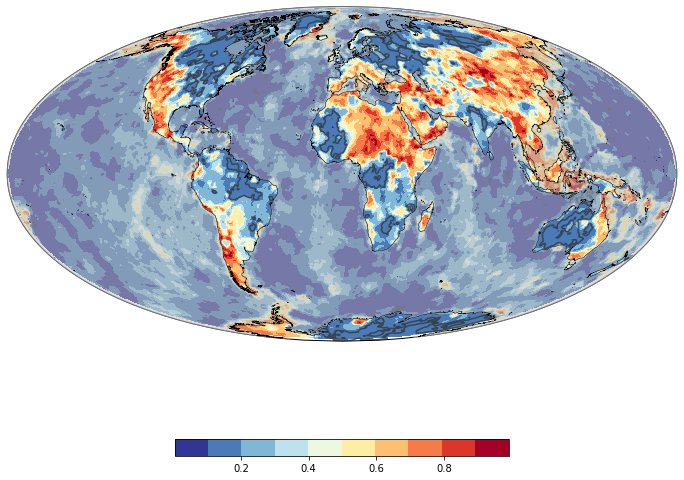

In [7]:
## Relative thickness of crust

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection2)
ax.set_global()

colormap = plt.cm.get_cmap('RdYlBu_r', 10)

"""
Possible values are: 

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, 
Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2,
Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r,
RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10,
Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r,
YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, 
coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r,
gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r,
gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean,
ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r,
summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
"""

m = ax.imshow(cthickness/(cthickness+lthickness), origin='lower', 
          transform=base_projection,
          extent=global_extent, 
          zorder=0, 
          cmap=colormap, 
          interpolation="gaussian")

plt.colorbar(mappable=m, orientation="horizontal", shrink=0.5)

ax.contour(lab_depth, origin='lower', levels=[250], 
                 extent=global_extent, transform=base_projection, colors="#333333", alpha=0.75)



ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#BBBBBB")
ax.coastlines(resolution="50m", zorder=100, linewidth=0.5)


# fig.savefig("RelativeCrustalThickness.png", dpi=600)

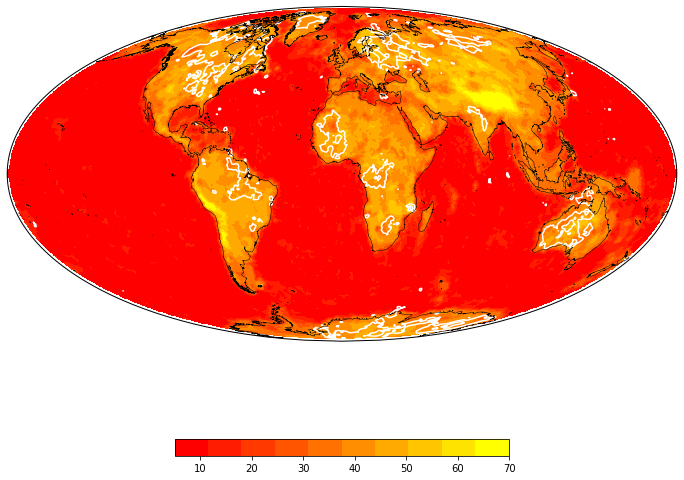

In [8]:
## 2nd Plot 

fig = plt.figure(figsize=(12, 12), facecolor="none")

ax  = plt.subplot(111, projection=projection2)
ax.set_global()

colormap = plt.cm.get_cmap('autumn', 10 )


m2 = ax.imshow(cthickness, origin='lower', transform=base_projection,
          extent=global_extent, zorder=0, cmap=colormap, vmin=5, vmax=70,
          interpolation="gaussian")

# m = ax.contourf(cthickness, origin='lower', levels=, 
#                 cmap=colormap, 
#                 extent=global_extent, transform=base_projection, 
#                 extend="max")


cb = plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.5)

# m = ax.contourf(lab_depth, origin='lower', levels=[250, 400], 
#                 colors=["#FFFFFF"], 
#                 extent=global_extent, transform=base_projection, extend="max",
#                 alpha=0.25)


m = ax.contour(lab_depth, origin='lower', levels=[250, ], 
                colors=["#FFFFFF"], 
                extent=global_extent, transform=base_projection, extend="max",
                alpha=1.)

# ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#BBBBBB")
ax.coastlines(resolution="50m", zorder=100, linewidth=0.5)


# plt.savefig("CrustalThickness.png", dpi=600 )

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


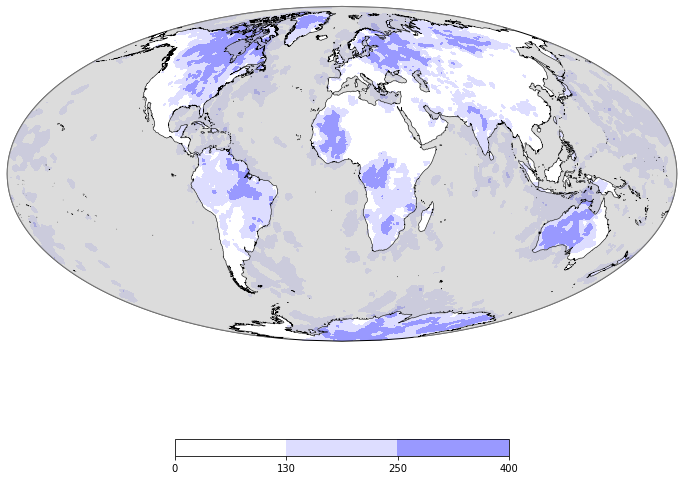

In [9]:
## Contours of LAB 

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection2)
ax.set_global()

m = ax.contourf(lab_depth, origin='lower', levels=[0, 130, 250, 400], 
                colors=[ "#FFFFFF", "#DDDDFF", "#9999FF"], 
                extent=global_extent, transform=base_projection, # extend="max",
                linewidth=0.25)


# ax.contour(lab_depth, origin='lower', levels=[130, 250], 
#                  extent=global_extent, transform=base_projection, colors="#555555")

plt.colorbar(mappable=m, orientation="horizontal", shrink=0.5)


ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#BBBBBB")
ax.coastlines(resolution="50m", zorder=100, linewidth=0.5)



plt.savefig("LithosphereThickness.png", dpi=600)